<a href="https://colab.research.google.com/github/kaveesha82/Telco-Customer-Churn/blob/main/Decision_Tree_of_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###library importing


In [ ]:
#libarary importing
print("importing libraries")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, recall_score,
                             precision_score, f1_score, confusion_matrix,
                             roc_curve, auc, precision_recall_curve)
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

importing libraries


###data loading

In [ ]:
print("loading data set")

# Load the dataset - make sure the file is uploaded to Colab
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

# Display first few rows to understand structure
print("First 5 rows of the dataset:")
print(df.head())
print("\n")

# Check data types
print("Data types of each column:")
print(df.dtypes)
print("\n")


loading data set
Dataset loaded successfully!
Shape: 7043 rows × 21 columns

First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber opt

###EDA

In [ ]:
print("exploratary data analaysis\n")

#Dataset Overview
print("data set overview")

print(f"Total Records: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1]}")
print(f"\nTarget Variable Distribution:")
print(df['Churn'].value_counts())
print(f"\nChurn Rate: {(df['Churn'].value_counts()['Yes'] / len(df) * 100):.2f}%")

# Calculate class imbalance ratio
churn_counts = df['Churn'].value_counts()
imbalance_ratio = churn_counts['No'] / churn_counts['Yes']
print(f"Class Imbalance Ratio (No:Yes): {imbalance_ratio:.2f}:1")

# Missing Value Analysis

# Check for missing values
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values(
    'Missing_Count', ascending=False
)

if len(missing_summary) > 0:
    print("Columns with missing values:")
    print(missing_summary.to_string(index=False))
else:
    print("✓ No explicit missing values found")

# Check for hidden missing values in TotalCharges (often stored as whitespace)
print(f"\nChecking TotalCharges for hidden missing values...")
total_charges_spaces = df[df['TotalCharges'] == ' '].shape[0]
print(f"Found {total_charges_spaces} records with whitespace in TotalCharges")


exploratary data analaysis

data set overview
Total Records: 7,043
Total Features: 21

Target Variable Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.54%
Class Imbalance Ratio (No:Yes): 2.77:1
✓ No explicit missing values found

Checking TotalCharges for hidden missing values...
Found 11 records with whitespace in TotalCharges


###Numerical Features summary


Descriptive Statistics:
            tenure  MonthlyCharges
count  7043.000000     7043.000000
mean     32.371149       64.761692
std      24.559481       30.090047
min       0.000000       18.250000
25%       9.000000       35.500000
50%      29.000000       70.350000
75%      55.000000       89.850000
max      72.000000      118.750000
3.4 CHURN-SPECIFIC NUMERICAL ANALYSIS

tenure:
  Churned customers     → Mean:    17.98 | Median:    10.00
  Retained customers    → Mean:    37.57 | Median:    38.00
  Difference (Churn-No) → Mean:   -19.59 | Median:   -28.00

MonthlyCharges:
  Churned customers     → Mean:    74.44 | Median:    79.65
  Retained customers    → Mean:    61.27 | Median:    64.43
  Difference (Churn-No) → Mean:    13.18 | Median:    15.22

TotalCharges:
  Churned customers     → Mean:  1531.80 | Median:   703.55
  Retained customers    → Mean:  2555.34 | Median:  1683.60
  Difference (Churn-No) → Mean: -1023.55 | Median:  -980.05
geneatin visualization for numerical valu

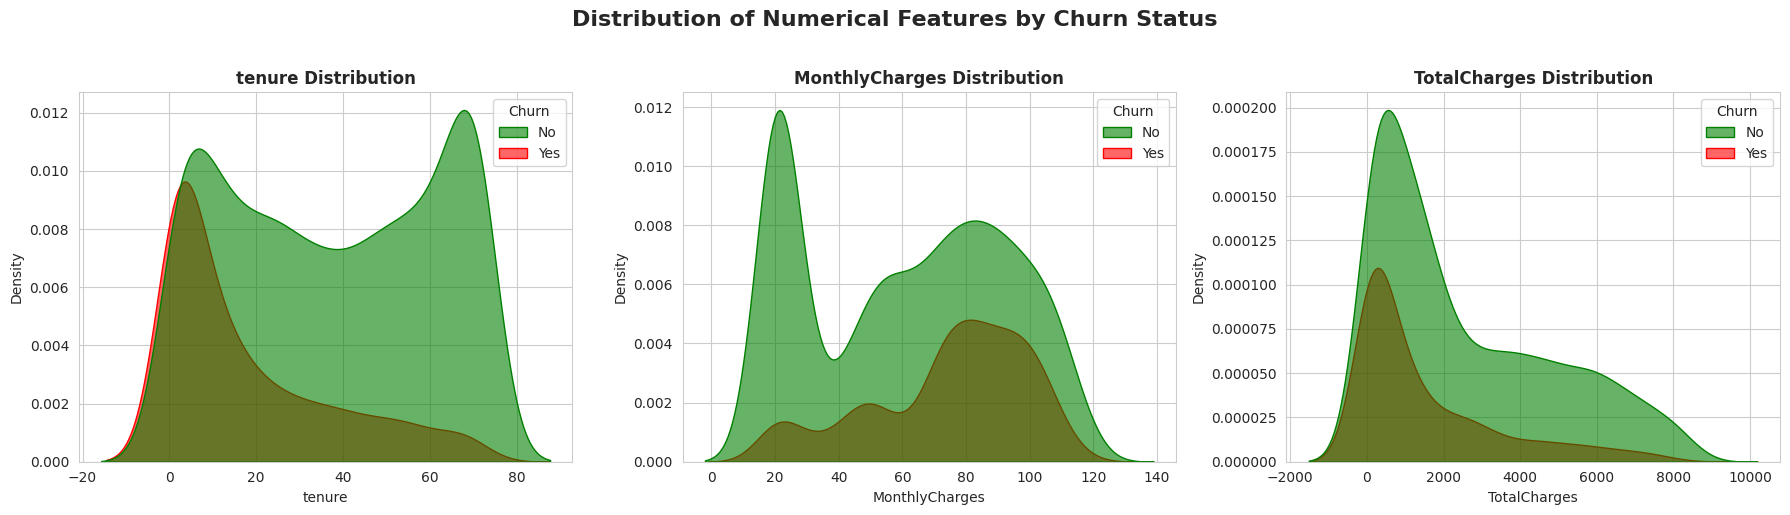

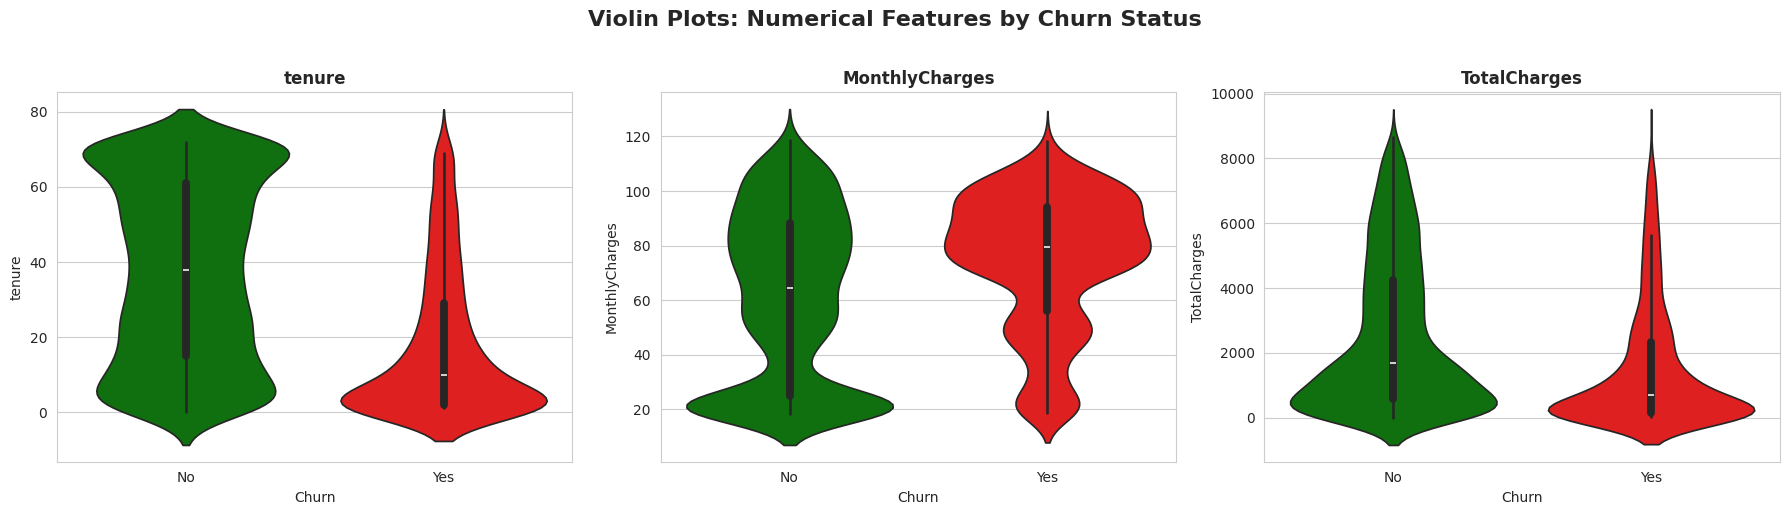

In [ ]:

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
print("\nDescriptive Statistics:")
print(df[numerical_features].describe())

#churn specific  summmary

print("3.4 CHURN-SPECIFIC NUMERICAL ANALYSIS")

# handle TotalCharges conversion for analysis
df_temp = df.copy()
df_temp['TotalCharges'] = pd.to_numeric(df_temp['TotalCharges'], errors='coerce')

for col in numerical_features:
    churn_yes = df_temp[df_temp['Churn'] == 'Yes'][col].dropna()
    churn_no = df_temp[df_temp['Churn'] == 'No'][col].dropna()

    print(f"\n{col}:")
    print(f"  Churned customers     → Mean: {churn_yes.mean():>8.2f} | Median: {churn_yes.median():>8.2f}")
    print(f"  Retained customers    → Mean: {churn_no.mean():>8.2f} | Median: {churn_no.median():>8.2f}")
    print(f"  Difference (Churn-No) → Mean: {(churn_yes.mean() - churn_no.mean()):>8.2f} | Median: {(churn_yes.median() - churn_no.median()):>8.2f}")

# visualiztion Numerical Features
print("geneatin visualization for numerical values")

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Create a clean dataframe for visualization
df_viz = df_temp.copy()
df_viz['TotalCharges'] = df_viz['TotalCharges'].fillna(0)

# KDE Plots - Show distribution overlap
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Numerical Features by Churn Status',
             fontsize=16, fontweight='bold', y=1.02)

for idx, col in enumerate(numerical_features):
    sns.kdeplot(
        data=df_viz, x=col, hue='Churn',
        fill=True, alpha=0.6, palette={'Yes': 'red', 'No': 'green'},
        ax=axes[idx], bw_adjust=1.2
    )
    axes[idx].set_title(f'{col} Distribution', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Violin Plots - Show distribution shape and outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Violin Plots: Numerical Features by Churn Status',
             fontsize=16, fontweight='bold', y=1.02)

for idx, col in enumerate(numerical_features):
    sns.violinplot(
        x='Churn', y=col, data=df_viz,
        palette={'Yes': 'red', 'No': 'green'}, ax=axes[idx]
    )
    axes[idx].set_title(f'{col}', fontweight='bold')

plt.tight_layout()
plt.show()



###cetagorical feature analysis

Catergorical data analysis


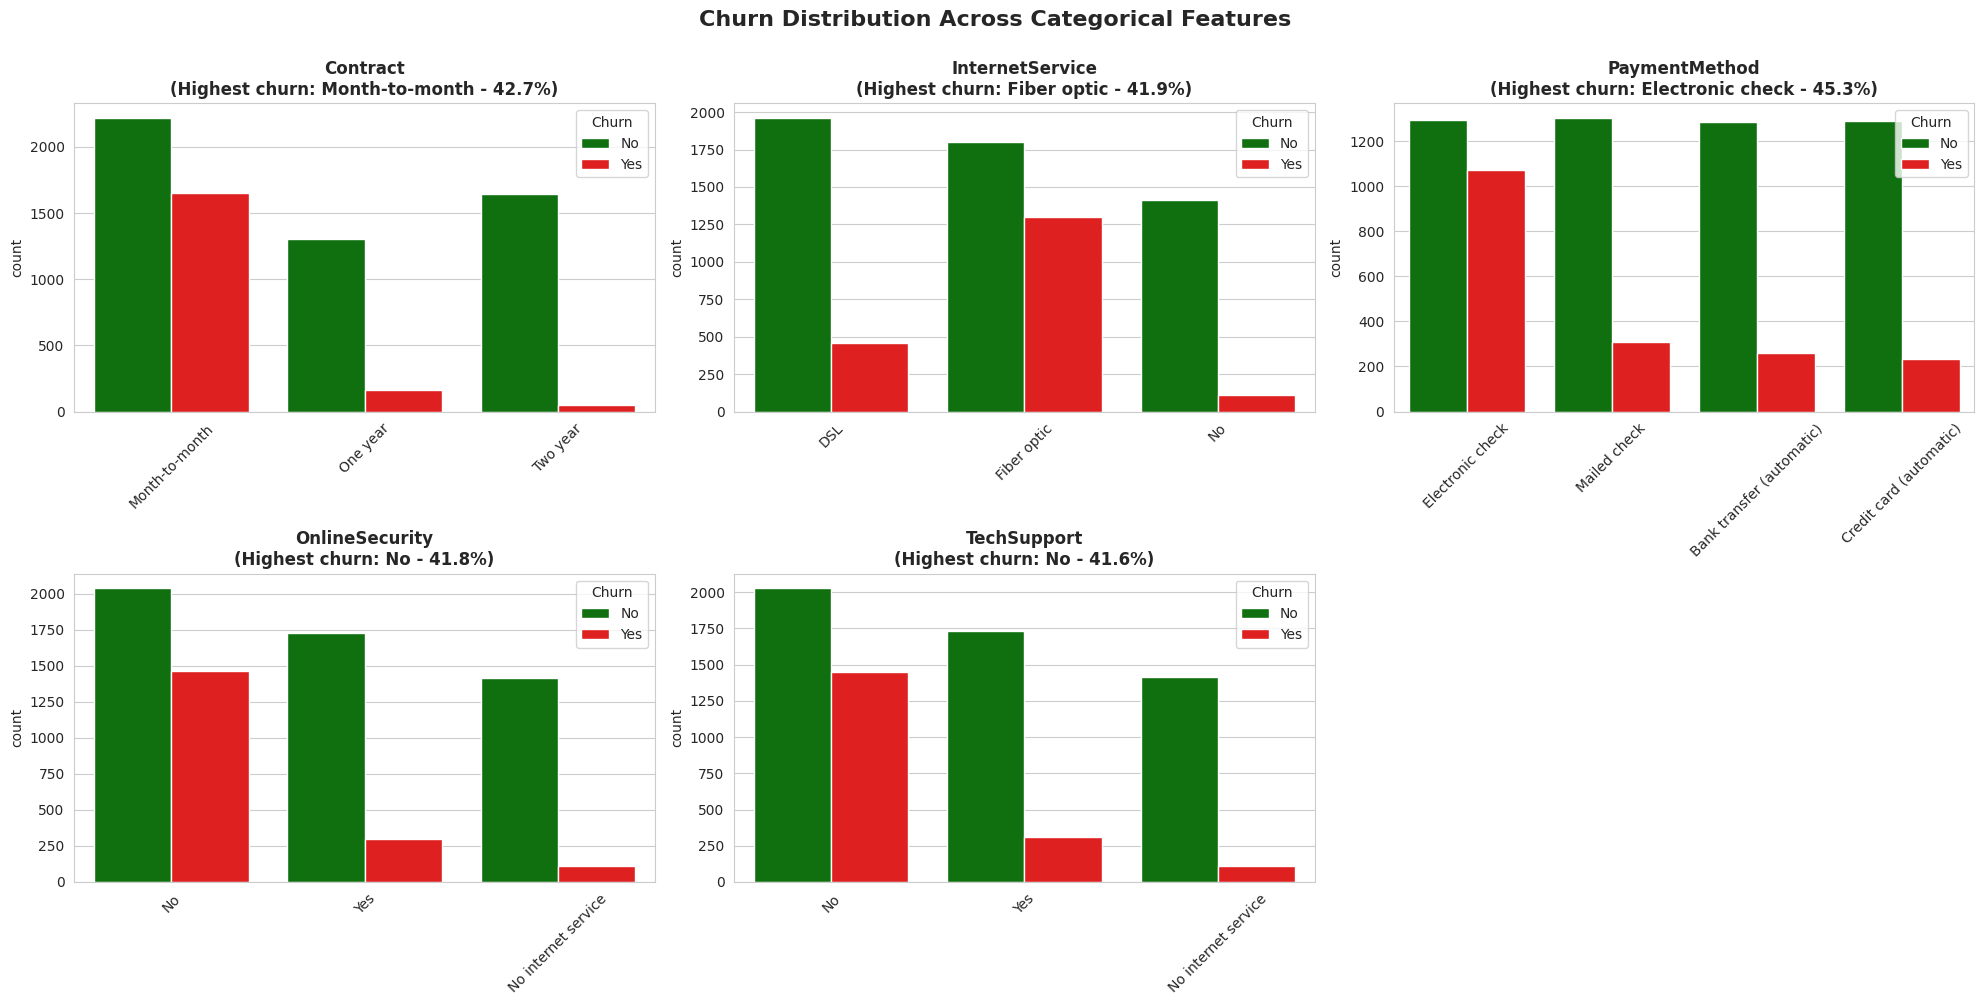

In [ ]:
print("Catergorical data analysis")

# categorical features for analysis
key_categorical = ['Contract', 'InternetService', 'PaymentMethod',
                   'OnlineSecurity', 'TechSupport']

# Count plots for key categorical features
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Churn Distribution Across Categorical Features',
             fontsize=16, fontweight='bold', y=1.00)
axes = axes.flatten()

for idx, col in enumerate(key_categorical):
    if col in df.columns:
        # Calculate churn rate per category
        churn_rate = df.groupby(col)['Churn'].apply(
            lambda x: (x == 'Yes').sum() / len(x) * 100
        ).sort_values(ascending=False)

        sns.countplot(
            x=col, hue='Churn', data=df,
            palette={'Yes': 'red', 'No': 'green'}, ax=axes[idx]
        )
        axes[idx].set_title(f'{col}\n(Highest churn: {churn_rate.index[0]} - {churn_rate.iloc[0]:.1f}%)',
                           fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].set_xlabel('')

# Remove extra subplot
if len(key_categorical) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()



###High Risk Customer Segments

In [ ]:
print("high risk segments")

# Identify high-risk segments based on multiple factors
risk_analysis = df.groupby(['Contract', 'InternetService', 'PaymentMethod']).agg({
    'Churn': lambda x: (x == 'Yes').sum() / len(x) * 100,
    'customerID': 'count'
}).rename(columns={'Churn': 'Churn_Rate_%', 'customerID': 'Customer_Count'})

risk_analysis = risk_analysis[risk_analysis['Customer_Count'] >= 10]  # Filter small segments
risk_analysis = risk_analysis.sort_values('Churn_Rate_%', ascending=False).head(10)

print("\nTop 10 High-Risk Customer Segments:")
print(risk_analysis.to_string())


high risk segments

Top 10 High-Risk Customer Segments:
                                                          Churn_Rate_%  Customer_Count
Contract       InternetService PaymentMethod                                          
Month-to-month Fiber optic     Electronic check              60.367253            1307
                               Mailed check                  50.746269             201
                               Bank transfer (automatic)     45.565749             327
                               Credit card (automatic)       41.638225             293
               DSL             Electronic check              40.506329             474
                               Mailed check                  30.790191             367
                               Credit card (automatic)       27.027027             185
One year       Fiber optic     Electronic check              26.020408             196
Month-to-month No              Mailed check                  20.615385    

###Data cleaning and preprocessing

In [ ]:
print("data cleaning and preprocessing")

# Make a copy for processing
df_clean = df.copy()


# handle missing values

print("handle missing values\n")

# Convert TotalCharges to numeric (whitespace becomes NaN)
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
print(f"\nConverted TotalCharges to numeric: {df_clean['TotalCharges'].isnull().sum()} NaN values found")

# fill NaN in TotalCharges with 0
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(0)
print(f" \nFilled NaN values in TotalCharges with 0")


# 4.2: Remove Unnecessary Features
print("remove unneccearrsy features")

# drop customerID
if 'customerID' in df_clean.columns:
    df_clean = df_clean.drop('customerID', axis=1)
    print("\n Dropped 'customerID' (high cardinality identifier)")


# 4.3: Remove Duplicates
print("\nRemove duplicates")

initial_rows = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
removed_duplicates = initial_rows - df_clean.shape[0]
print(f"\nRemoved {removed_duplicates} duplicate rows")
print(f"Dataset shape after cleaning: {df_clean.shape}")

# encode target variable
print("\nencode target variable")

# Encode Churn: Yes → 1, No → 0
df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})
print(" \nTarget variable 'Churn' encoded: Yes → 1, No → 0")
print(f"  New distribution:\n{df_clean['Churn'].value_counts()}")

data cleaning and preprocessing
handle missing values


Converted TotalCharges to numeric: 11 NaN values found
 
Filled NaN values in TotalCharges with 0
remove unneccearrsy features

 Dropped 'customerID' (high cardinality identifier)

Remove duplicates

Removed 22 duplicate rows
Dataset shape after cleaning: (7021, 20)

encode target variable
 
Target variable 'Churn' encoded: Yes → 1, No → 0
  New distribution:
Churn
0    5164
1    1857
Name: count, dtype: int64


###feature engineering

In [ ]:
print("feature engineering")

#Ccreating Derived Features
print("creating deriving featurren\n")

# Store original for encoding later
df_features = df_clean.copy()

# Tenure groups (customer lifecycle stage)
df_features['tenure_group'] = pd.cut(
    df_features['tenure'],
    bins=[0, 12, 24, 48, 72],
    labels=['New_0-1yr', 'Growing_1-2yr', 'Mature_2-4yr', 'Loyal_4-6yr']
)
print("1) Created 'tenure_group': Categorizes customers by lifecycle stage")

# Average charges per month
df_features['avg_charges_per_month'] = df_features['TotalCharges'] / (df_features['tenure'] + 1)
print("2) Created 'avg_charges_per_month': Average spending per month")

# High monthly charges flag
monthly_charges_median = df_features['MonthlyCharges'].median()
df_features['high_monthly_charges'] = (
    df_features['MonthlyCharges'] > monthly_charges_median
).astype(int)
print(f"3)Created 'high_monthly_charges': Flag for charges > ${monthly_charges_median:.2f}")

# Count of subscribed services
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
df_features['total_services'] = df_features[service_cols].apply(
    lambda x: (x == 'Yes').sum(), axis=1
)
print("4)Created 'total_services': Count of additional services subscribed")

# Has both phone and internet
df_features['has_phone_and_internet'] = (
    (df_features['PhoneService'] == 'Yes') &
    (df_features['InternetService'] != 'No')
).astype(int)
print("5)Created 'has_phone_and_internet': Bundle indicator")

# High-value customer flag
df_features['is_high_value_customer'] = (
    (df_features['Contract'] == 'Two year') &
    (df_features['MonthlyCharges'] > df_features['MonthlyCharges'].quantile(0.75))
).astype(int)
print("6)Created 'is_high_value_customer': Long-term + high-spending customers")

print(f"\n Total features after engineering: {df_features.shape[1]}")

feature engineering
creating deriving featurren

1) Created 'tenure_group': Categorizes customers by lifecycle stage
2) Created 'avg_charges_per_month': Average spending per month
3)Created 'high_monthly_charges': Flag for charges > $70.40
4)Created 'total_services': Count of additional services subscribed
5)Created 'has_phone_and_internet': Bundle indicator
6)Created 'is_high_value_customer': Long-term + high-spending customers

 Total features after engineering: 26


###correlation analysis

Correlation analysis


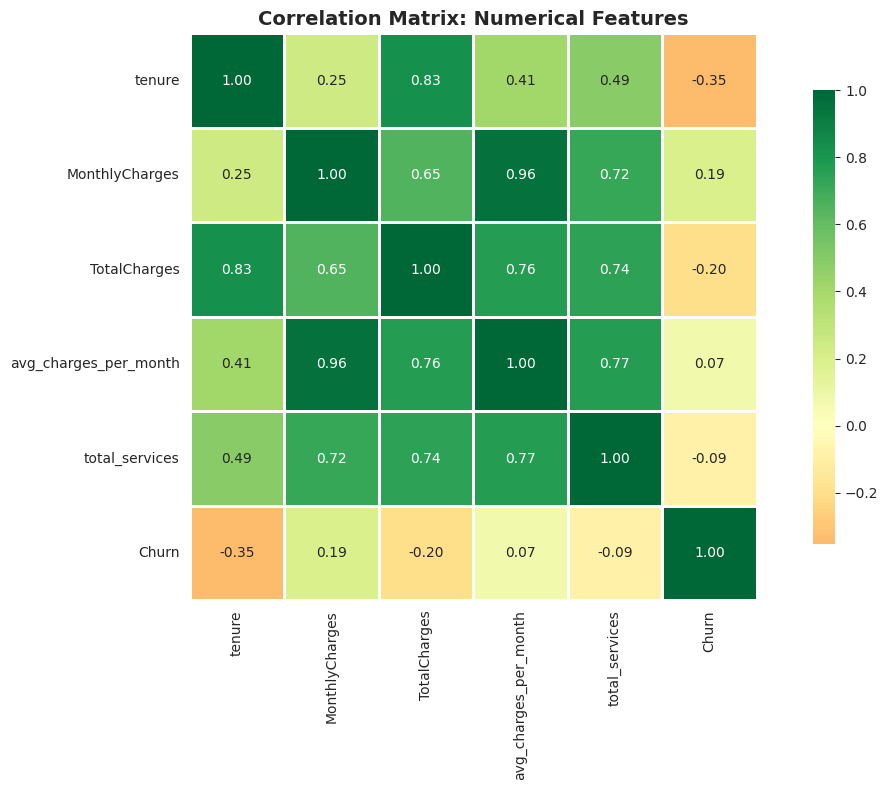

 Correlation matrix generated

 Key Correlations with Churn:
   MonthlyCharges                :  0.195
   avg_charges_per_month         :  0.075
   total_services                : -0.086
   TotalCharges                  : -0.197
   tenure                        : -0.352


In [ ]:
print("Correlation analysis")

#select numerical columns for correlation
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges',
                  'avg_charges_per_month', 'total_services', 'Churn']

corr_matrix = df_features[numerical_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(" Correlation matrix generated")
print("\n Key Correlations with Churn:")
churn_corr = corr_matrix['Churn'].sort_values(ascending=False)
for feat, corr_val in churn_corr.items():
    if feat != 'Churn':
        print(f"   {feat:30s}: {corr_val:>6.3f}")

###feature encoding

In [ ]:
print("feature encoding")

# One Hot Encoding
print("one hot encoding for categoical featues")

# drop_first=True to avoid multicollinearity
df_encoded = pd.get_dummies(df_features, drop_first=True)
print(f"  One hot encoding applied")
print(f"  Shape after encoding: {df_encoded.shape}")
print(f"  Total features created: {df_encoded.shape[1] - 1} (without Y-churn)")

#
# 6.2: Separate Features and Target
print("separating feature and target\n")

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
# print(f"  Class distribution: {dict(y.value_counts())}")


feature encoding
one hot encoding for categoical featues
  One hot encoding applied
  Shape after encoding: (7021, 39)
  Total features created: 38 (without Y-churn)
separating feature and target

Features (X): (7021, 38)
Target (y): (7021,)


###Feature scaling for NN

In [ ]:
print("feature scaling\n")

# numerical columns
numerical_cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges', 'avg_charges_per_month']

# Create unscaled version (for Decision Tree)
X_unscaled = X.copy()

# Create scaled version (for Neural Network)
scaler = MinMaxScaler()
X_scaled = X.copy()
X_scaled[numerical_cols_to_scale] = scaler.fit_transform(X_scaled[numerical_cols_to_scale])

print(" MinMaxScaler applied to numerical features")
print(f"  Scaled features: {numerical_cols_to_scale}")


feature scaling

 MinMaxScaler applied to numerical features
  Scaled features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'avg_charges_per_month']


###Train Test Split

In [ ]:
print("\n" )
print("Train split data")


# split unscaled data for Decision Tree
X_train, X_test, y_train, y_test = train_test_split(
    X_unscaled, y, test_size=0.2, random_state=42, stratify=y
)

# Split scaled data for Neural Network
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Train-Test Split Complete (80-20 split with stratification)")
print(f"\n  Training set (unscaled for DT): {X_train.shape}")
print(f"  Test set (unscaled for DT):     {X_test.shape}")
print(f"  Training set (scaled for NN):   {X_train_scaled.shape}")
print(f"  Test set (scaled for NN):       {X_test_scaled.shape}")

print(f"\n  Training target distribution: {dict(y_train.value_counts())}")
print(f"  Test target distribution:     {dict(y_test.value_counts())}")




Train split data
 Train-Test Split Complete (80-20 split with stratification)

  Training set (unscaled for DT): (5616, 38)
  Test set (unscaled for DT):     (1405, 38)
  Training set (scaled for NN):   (5616, 38)
  Test set (scaled for NN):       (1405, 38)

  Training target distribution: {0: np.int64(4131), 1: np.int64(1485)}
  Test target distribution:     {0: np.int64(1033), 1: np.int64(372)}


###Feature imprtoance Analysis

feature importance analysis
using Random forest for get importance features

top 20 Important Features:
                       Feature  Importance
                  TotalCharges    0.144764
                        tenure    0.133501
                MonthlyCharges    0.129124
         avg_charges_per_month    0.125125
PaymentMethod_Electronic check    0.038429
   InternetService_Fiber optic    0.036830
                total_services    0.031408
                   gender_Male    0.023159
             Contract_Two year    0.022936
          PaperlessBilling_Yes    0.022802
            OnlineSecurity_Yes    0.019420
             Contract_One year    0.019352
                   Partner_Yes    0.019216
               TechSupport_Yes    0.018497
                 SeniorCitizen    0.017850
      tenure_group_Loyal_4-6yr    0.017467
                Dependents_Yes    0.016735
              OnlineBackup_Yes    0.016498
             MultipleLines_Yes    0.015365
          DeviceProtection_Yes    0.

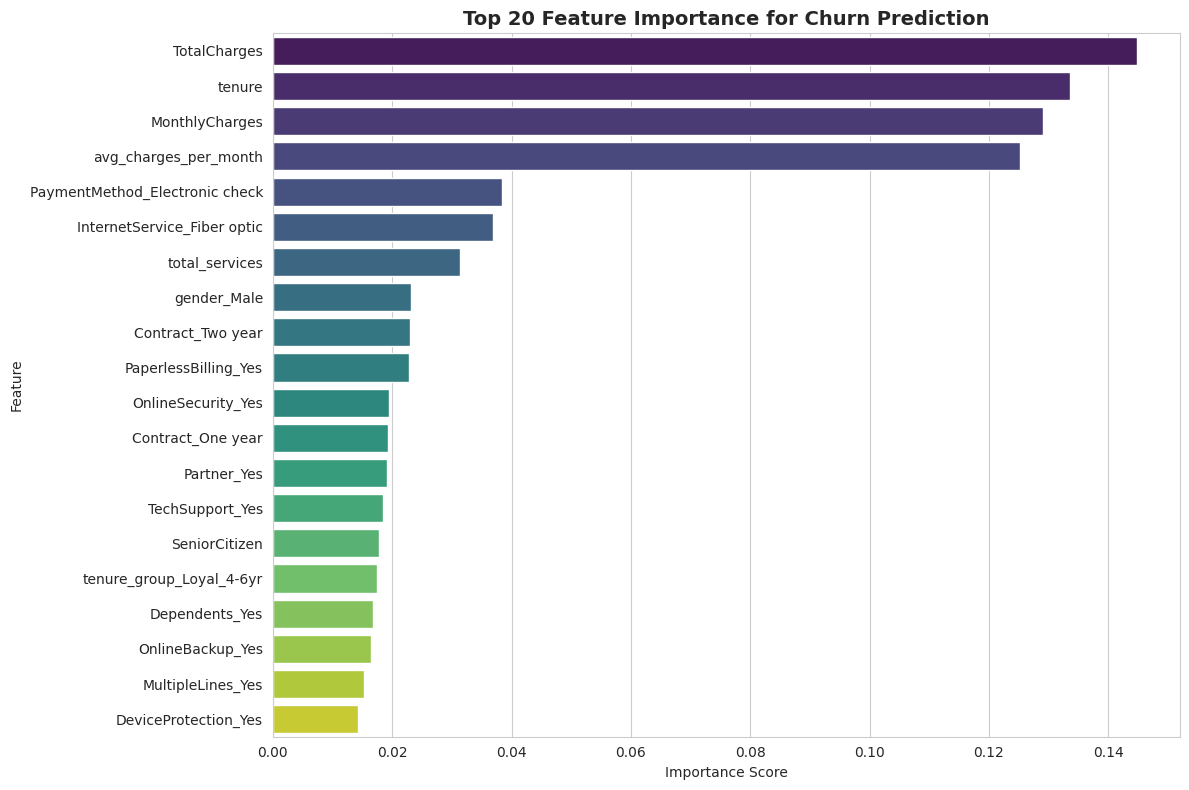

In [ ]:
print("feature importance analysis")

# Use Random Forest to get feature importance
print("using Random forest for get importance features")
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_train, y_train)

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_temp.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

print("\ntop 20 Important Features:")
print(feature_importance_df.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('Top 20 Feature Importance for Churn Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



###decision tree base model

baseline model
Base line model results
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1033
           1       0.49      0.47      0.48       372

    accuracy                           0.73      1405
   macro avg       0.65      0.64      0.65      1405
weighted avg       0.72      0.73      0.73      1405

   Key Metrics (Class 1 - Churn):
   Accuracy:  0.7288
   Precision: 0.4873
   Recall:    0.4651
   F1-Score:  0.4759


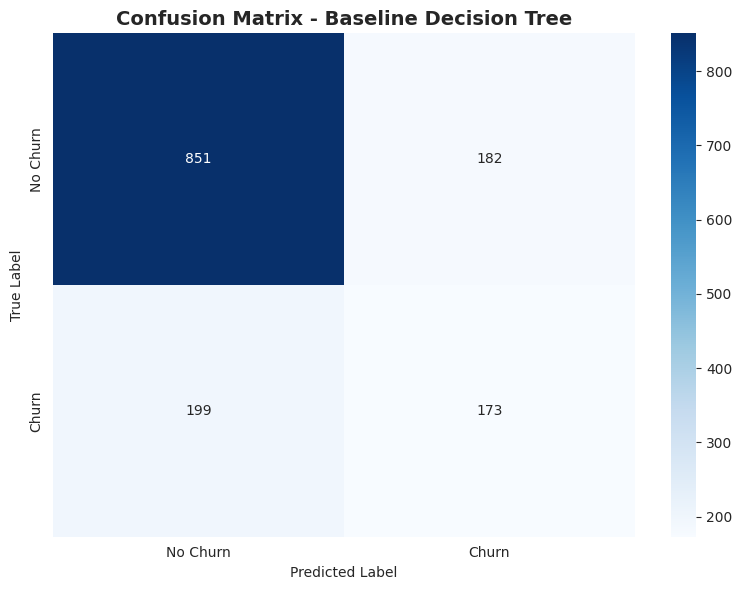

In [ ]:
print("baseline model")


# Train baseline Decision Tree with class balancing
baseline_dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
baseline_dt.fit(X_train, y_train)

# Make predictions
y_pred_dt_baseline = baseline_dt.predict(X_test)

# Get classification report
dt_baseline_report = classification_report(y_test, y_pred_dt_baseline, output_dict=True)

print("Base line model results")
print(classification_report(y_test, y_pred_dt_baseline))

# Store metrics
dt_baseline_metrics = {
    'accuracy': dt_baseline_report['accuracy'],
    'precision': dt_baseline_report['1']['precision'],
    'recall': dt_baseline_report['1']['recall'],
    'f1': dt_baseline_report['1']['f1-score']
}

print(f"   Key Metrics (Class 1 - Churn):")
print(f"   Accuracy:  {dt_baseline_metrics['accuracy']:.4f}")
print(f"   Precision: {dt_baseline_metrics['precision']:.4f}")
print(f"   Recall:    {dt_baseline_metrics['recall']:.4f}")
print(f"   F1-Score:  {dt_baseline_metrics['f1']:.4f}")

# Confusion Matrix with Heatmap
cm_dt_baseline = confusion_matrix(y_test, y_pred_dt_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_baseline, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Baseline Decision Tree', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()



###Decision tree with Hyperperameter tuning

decision tree with tuning
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

 hyper eprameteer tunnig results 

 Best Parameters Found:
   criterion           : entropy
   max_depth           : 5
   max_features        : None
   min_samples_leaf    : 5
   min_samples_split   : 2
   splitter            : best

 Best Cross-Validation F1 Score: 0.6138
hyper perameteer tunnig results - RESULTS
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1033
           1       0.47      0.79      0.59       372

    accuracy                           0.71      1405
   macro avg       0.69      0.74      0.69      1405
weighted avg       0.79      0.71      0.73      1405

   Key Metrics (Class 1 - Churn):
   Accuracy:  0.7132
   Precision: 0.4750
   Recall:    0.7903
   F1-Score:  0.5933


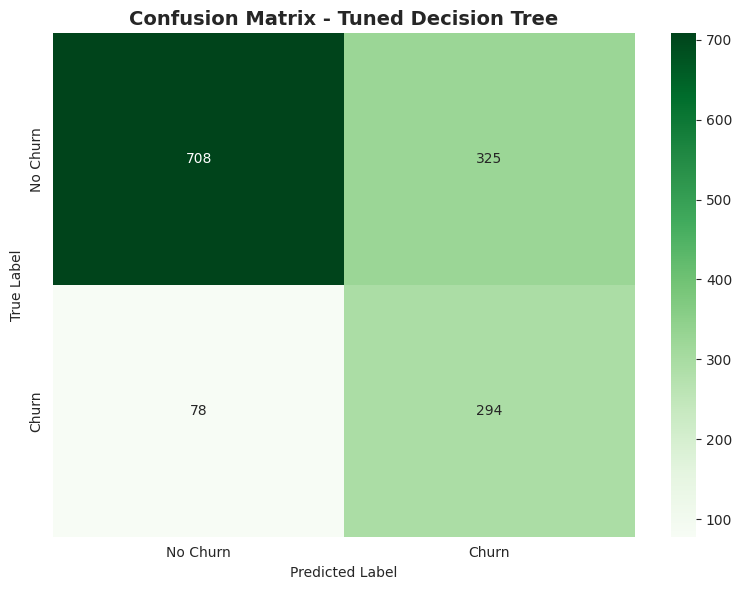

In [ ]:
print("decision tree with tuning")


# Define parameter grid
param_grid_dt = {
    'max_depth': [3, 5, 7, 9, 11, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'splitter': ['best']
}

# GridSearchCV with cross-validation
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid_dt,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
dt_grid.fit(X_train, y_train)

# Get best model
best_dt = dt_grid.best_estimator_
y_pred_dt_tuned = best_dt.predict(X_test)

print("\n hyper eprameteer tunnig results \n")
print(f" Best Parameters Found:")
for param, value in dt_grid.best_params_.items():
    print(f"   {param:20s}: {value}")

print(f"\n Best Cross-Validation F1 Score: {dt_grid.best_score_:.4f}")

# Get classification report for tuned model
dt_tuned_report = classification_report(y_test, y_pred_dt_tuned, output_dict=True)

print("hyper perameteer tunnig results - RESULTS")

print(classification_report(y_test, y_pred_dt_tuned))

# Store metrics
dt_tuned_metrics = {
    'accuracy': dt_tuned_report['accuracy'],
    'precision': dt_tuned_report['1']['precision'],
    'recall': dt_tuned_report['1']['recall'],
    'f1': dt_tuned_report['1']['f1-score']
}

print(f"   Key Metrics (Class 1 - Churn):")
print(f"   Accuracy:  {dt_tuned_metrics['accuracy']:.4f}")
print(f"   Precision: {dt_tuned_metrics['precision']:.4f}")
print(f"   Recall:    {dt_tuned_metrics['recall']:.4f}")
print(f"   F1-Score:  {dt_tuned_metrics['f1']:.4f}")

# Confusion Matrix with Heatmap
cm_dt_tuned = confusion_matrix(y_test, y_pred_dt_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_tuned, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Tuned Decision Tree', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

###comparison Baseline with Tuned model

Decision tree comparions between base line model and Tuned

   Metric  Baseline    Tuned  Improvement
 Accuracy  0.728826 0.713167    -0.015658
Precision  0.487324 0.474960    -0.012364
   Recall  0.465054 0.790323     0.325269
 F1-Score  0.475928 0.593340     0.117412


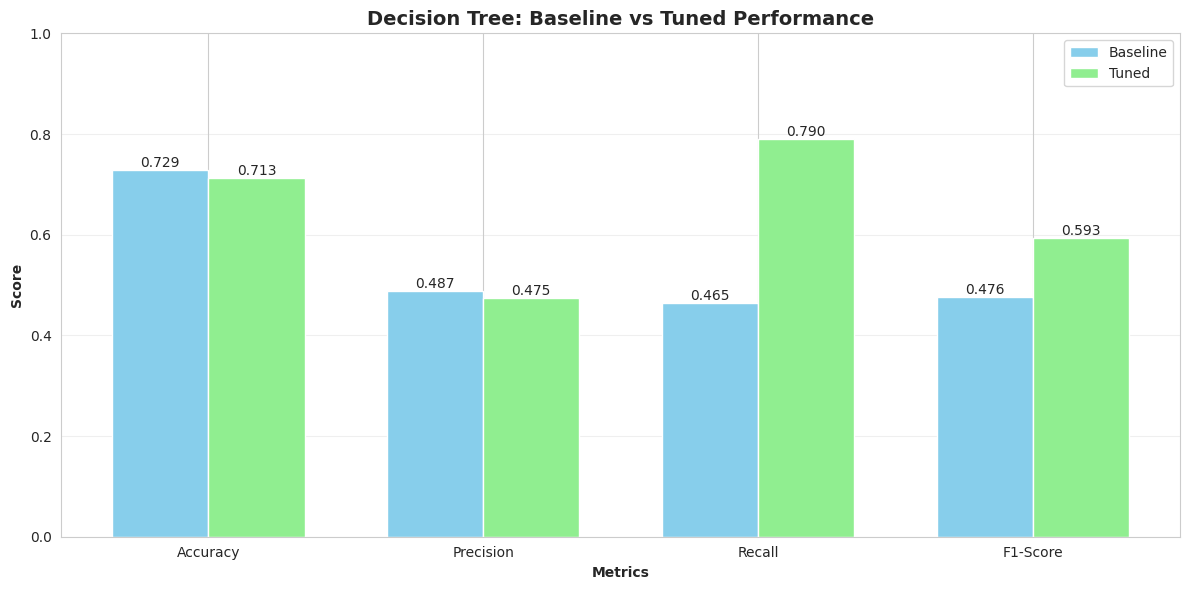

In [ ]:
print("Decision tree comparions between base line model and Tuned\n")

comparison_dt = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [
        dt_baseline_metrics['accuracy'],
        dt_baseline_metrics['precision'],
        dt_baseline_metrics['recall'],
        dt_baseline_metrics['f1']
    ],
    'Tuned': [
        dt_tuned_metrics['accuracy'],
        dt_tuned_metrics['precision'],
        dt_tuned_metrics['recall'],
        dt_tuned_metrics['f1']
    ]
})
comparison_dt['Improvement'] = comparison_dt['Tuned'] - comparison_dt['Baseline']

print(comparison_dt.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_dt['Metric']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_dt['Baseline'], width, label='Baseline', color='skyblue')
bars2 = ax.bar(x + width/2, comparison_dt['Tuned'], width, label='Tuned', color='lightgreen')

ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Decision Tree: Baseline vs Tuned Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_dt['Metric'])
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



###base line nurel network

Baseline nurerl network

baseline NN architecture


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5962 - loss: 0.6765 - val_accuracy: 0.7758 - val_loss: 0.4609
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7814 - loss: 0.4501 - val_accuracy: 0.7936 - val_loss: 0.4363
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7975 - loss: 0.4277 - val_accuracy: 0.7900 - val_loss: 0.4312
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8041 - loss: 0.4232 - val_accuracy: 0.7929 - val_loss: 0.4275
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7955 - loss: 0.4309 - val_accuracy: 0.7993 - val_loss: 0.4258
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7990 - loss: 0.4214 - val_accuracy: 0.7993 - val_loss: 0.4252
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7952 - loss: 0.4205 - val_accuracy: 0.7993 - val_loss: 0.4245
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8039 - loss: 0.4160 - val_accuracy: 0.

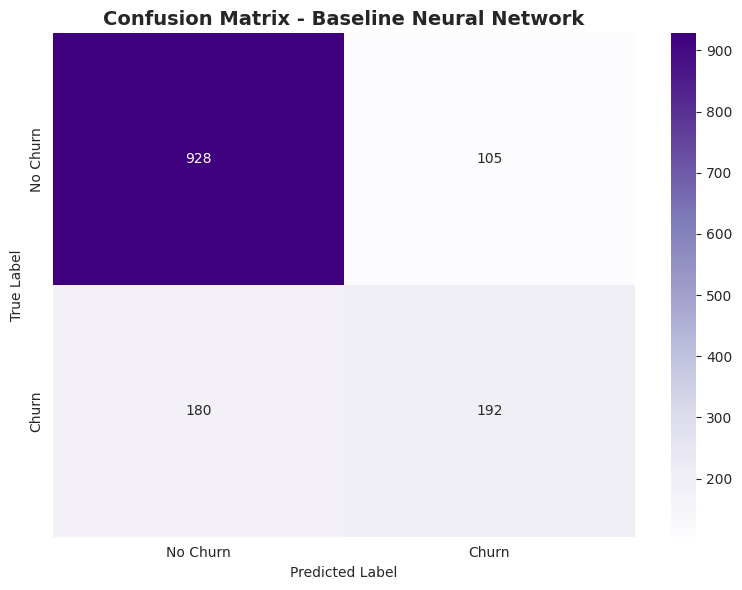

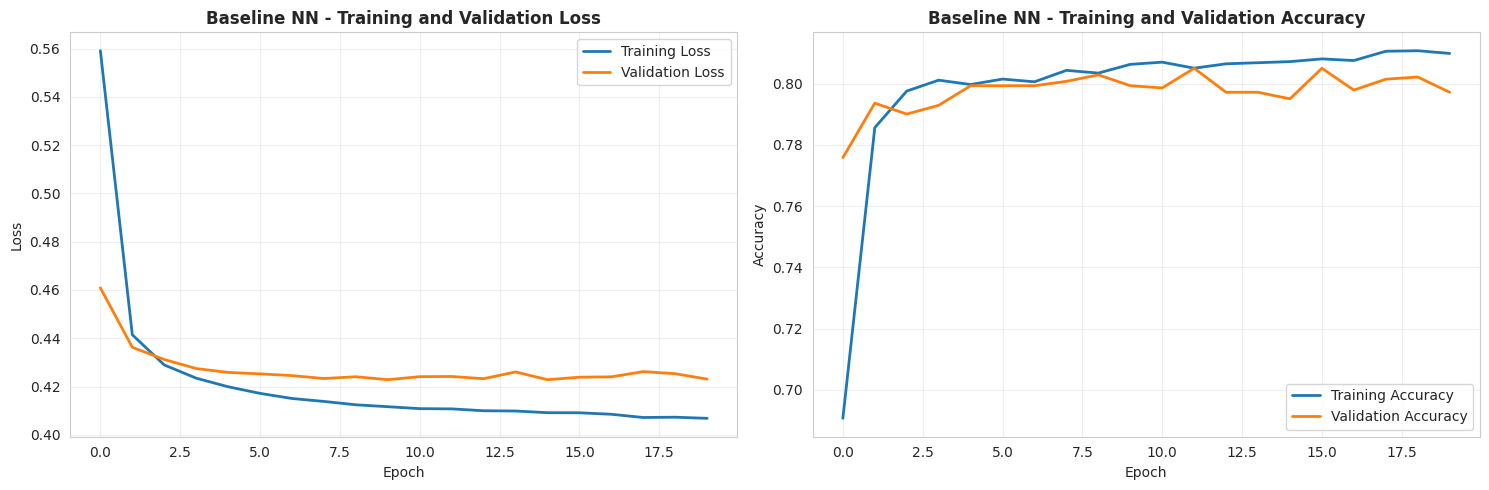

In [ ]:
print("Baseline nurerl network\n")


# Create baseline model
baseline_nn = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
baseline_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("baseline NN architecture")
baseline_nn.summary()

# Train the model
baseline_nn_history = baseline_nn.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Make predictions
y_pred_nn_baseline_proba = baseline_nn.predict(X_test_scaled)
y_pred_nn_baseline = (y_pred_nn_baseline_proba > 0.5).astype(int)

# Get classification report
nn_baseline_report = classification_report(y_test, y_pred_nn_baseline, output_dict=True)

print("/n Baseline NN - results /n ")
print(classification_report(y_test, y_pred_nn_baseline))

# Store metrics
nn_baseline_metrics = {
    'accuracy': nn_baseline_report['accuracy'],
    'precision': nn_baseline_report['1']['precision'],
    'recall': nn_baseline_report['1']['recall'],
    'f1': nn_baseline_report['1']['f1-score']
}

print(f"   Key Metrics (Class 1 - Churn):")
print(f"   Accuracy:  {nn_baseline_metrics['accuracy']:.4f}")
print(f"   Precision: {nn_baseline_metrics['precision']:.4f}")
print(f"   Recall:    {nn_baseline_metrics['recall']:.4f}")
print(f"   F1-Score:  {nn_baseline_metrics['f1']:.4f}")

# Confusion Matrix with Heatmap
cm_nn_baseline = confusion_matrix(y_test, y_pred_nn_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn_baseline, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Baseline Neural Network', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(baseline_nn_history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(baseline_nn_history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Baseline NN - Training and Validation Loss', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy plot
ax2.plot(baseline_nn_history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax2.plot(baseline_nn_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.set_title('Baseline NN - Training and Validation Accuracy', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()



###Tuned NN model


 Hyper perameter tuned Nurel network 
 
calculating class weight for imbalance data
Class Weights Calculated:
   Class 0 (No Churn): 0.6797
   Class 1 (Churn):    1.8909

 building nurel network 


────────────────────────────────────────────────────────────────────────────────
TUNED NEURAL NETWORK ARCHITECTURE
────────────────────────────────────────────────────────────────────────────────


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)


 Trainin tuned nurel network 

Epoch 1/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6201 - loss: 0.6385 - val_accuracy: 0.7594 - val_loss: 0.4859
Epoch 2/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7282 - loss: 0.5481 - val_accuracy: 0.7701 - val_loss: 0.4691
Epoch 3/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7589 - loss: 0.4940 - val_accuracy: 0.7673 - val_loss: 0.4681
Epoch 4/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7517 - loss: 0.5109 - val_accuracy: 0.7566 - val_loss: 0.4858
Epoch 5/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7456 - loss: 0.5002 - val_accuracy: 0.7630 - val_loss: 0.4789
Epoch 6/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7540 - loss: 0.4919 - val_accuracy: 0.7544 - val_loss: 0.4946
Epoch 7/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7519 - loss: 0.4918 - val_accuracy: 0.7601 - val_loss: 0.4778
Epoch 8/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 

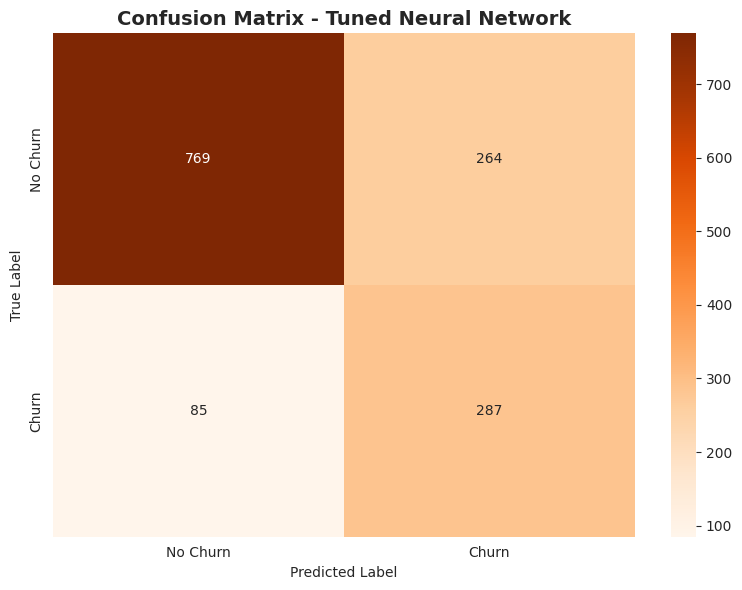

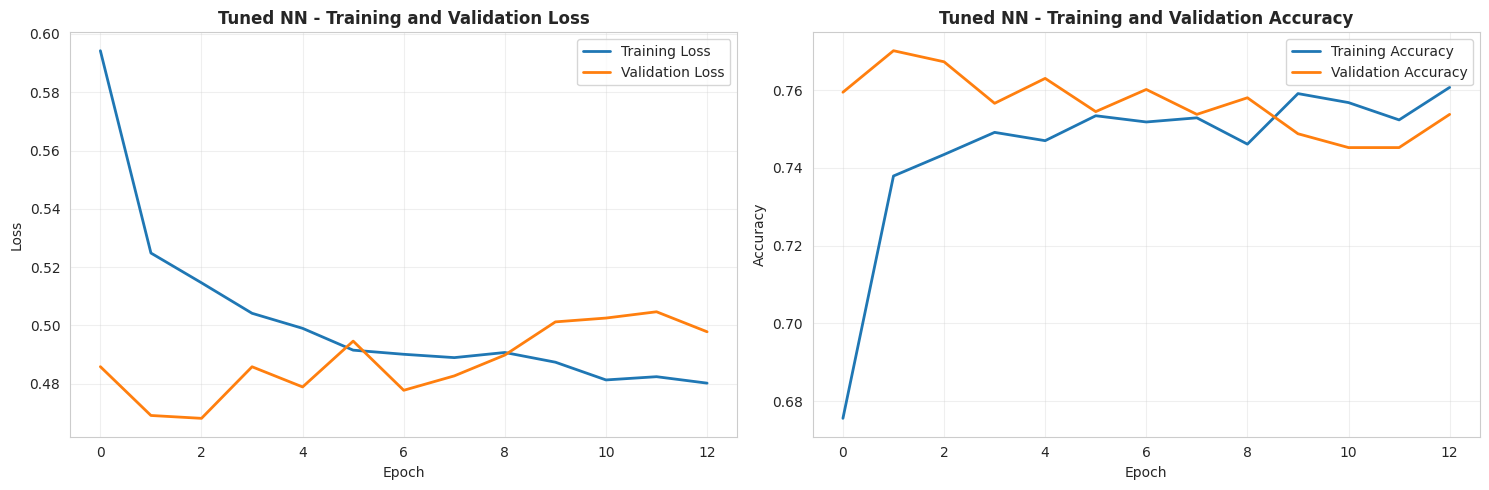

In [ ]:

print("\n Hyper perameter tuned Nurel network \n ")

print("calculating class weight for imbalance data")

class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: class_weights_arr[i] for i in range(len(class_weights_arr))}

print(f"Class Weights Calculated:")
print(f"   Class 0 (No Churn): {class_weights[0]:.4f}")
print(f"   Class 1 (Churn):    {class_weights[1]:.4f}")

# Build Tuned Neural Network
print("\n building nurel network \n")



# Create tuned model
tuned_nn = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(16, activation='relu'),

    Dense(1, activation='sigmoid')
])

# Use Adam optimizer with custom learning rate
optimizer = Adam(learning_rate=0.0007)

tuned_nn.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n" + "─"*80)
print("TUNED NEURAL NETWORK ARCHITECTURE")
print("─"*80)
tuned_nn.summary()

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train Tuned Neural Network
print("\n Trainin tuned nurel network \n")

tuned_nn_history = tuned_nn.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=120,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


# Optimize Decision Threshold
print("\n optimization decision threshold for best F1 Score \n ")

# Get probability predictions
y_pred_nn_tuned_proba = tuned_nn.predict(X_test_scaled)

# Find optimal threshold using precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_nn_tuned_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
#dafult threshold is 0.5

print(f"\n Optimal Threshold Found: {best_threshold:.4f}")
print(f"  Maximum F1-Score at this threshold: {f1_scores[best_idx]:.4f}")

# Apply optimal threshold
y_pred_nn_tuned = (y_pred_nn_tuned_proba > best_threshold).astype(int)

# Get classification report
nn_tuned_report = classification_report(y_test, y_pred_nn_tuned, output_dict=True)

print("\n Tuned nurel network results\n")
print(classification_report(y_test, y_pred_nn_tuned))

# Store metrics
nn_tuned_metrics = {
    'accuracy': nn_tuned_report['accuracy'],
    'precision': nn_tuned_report['1']['precision'],
    'recall': nn_tuned_report['1']['recall'],
    'f1': nn_tuned_report['1']['f1-score']
}

print(f"   Key Metrics (Class 1 - Churn):")
print(f"   Accuracy:  {nn_tuned_metrics['accuracy']:.4f}")
print(f"   Precision: {nn_tuned_metrics['precision']:.4f}")
print(f"   Recall:    {nn_tuned_metrics['recall']:.4f}")
print(f"   F1-Score:  {nn_tuned_metrics['f1']:.4f}")

# Confusion Matrix with Heatmap
cm_nn_tuned = confusion_matrix(y_test, y_pred_nn_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn_tuned, annot=True, fmt='d', cmap='Oranges', cbar=True,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Tuned Neural Network', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(tuned_nn_history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(tuned_nn_history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Tuned NN - Training and Validation Loss', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy plot
ax2.plot(tuned_nn_history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax2.plot(tuned_nn_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.set_title('Tuned NN - Training and Validation Accuracy', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


###Compare Based NN model with Tuned Model


 Base line NN model VS Tunned NN
   Metric  Baseline    Tuned  Improvement
 Accuracy  0.797153 0.751601    -0.045552
Precision  0.646465 0.520871    -0.125594
   Recall  0.516129 0.771505     0.255376
 F1-Score  0.573991 0.621885     0.047894


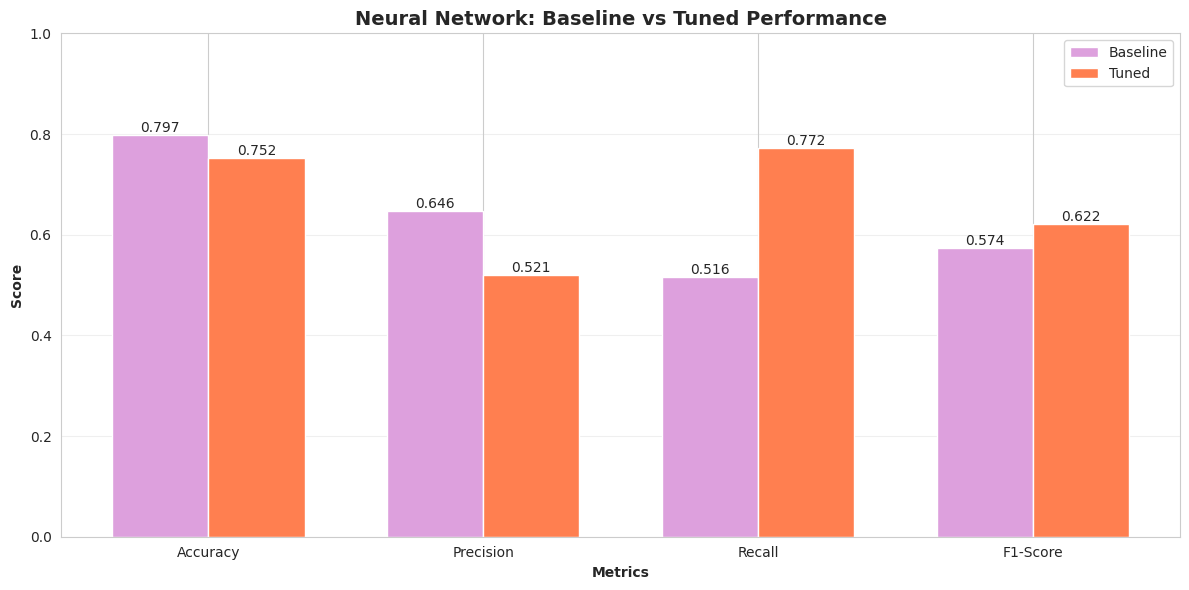


 model comparison 


 Final model cmparison table 


  final model comparison:
      Model  Accuracy  Precision   Recall  F1-Score
Baseline DT  0.728826   0.487324 0.465054  0.475928
   Tuned DT  0.713167   0.474960 0.790323  0.593340
Baseline NN  0.797153   0.646465 0.516129  0.573991
   Tuned NN  0.751601   0.520871 0.771505  0.621885

  best model: Tuned NN with F1-Score of 0.6219

 Confusion Matrix Comparison for al model 



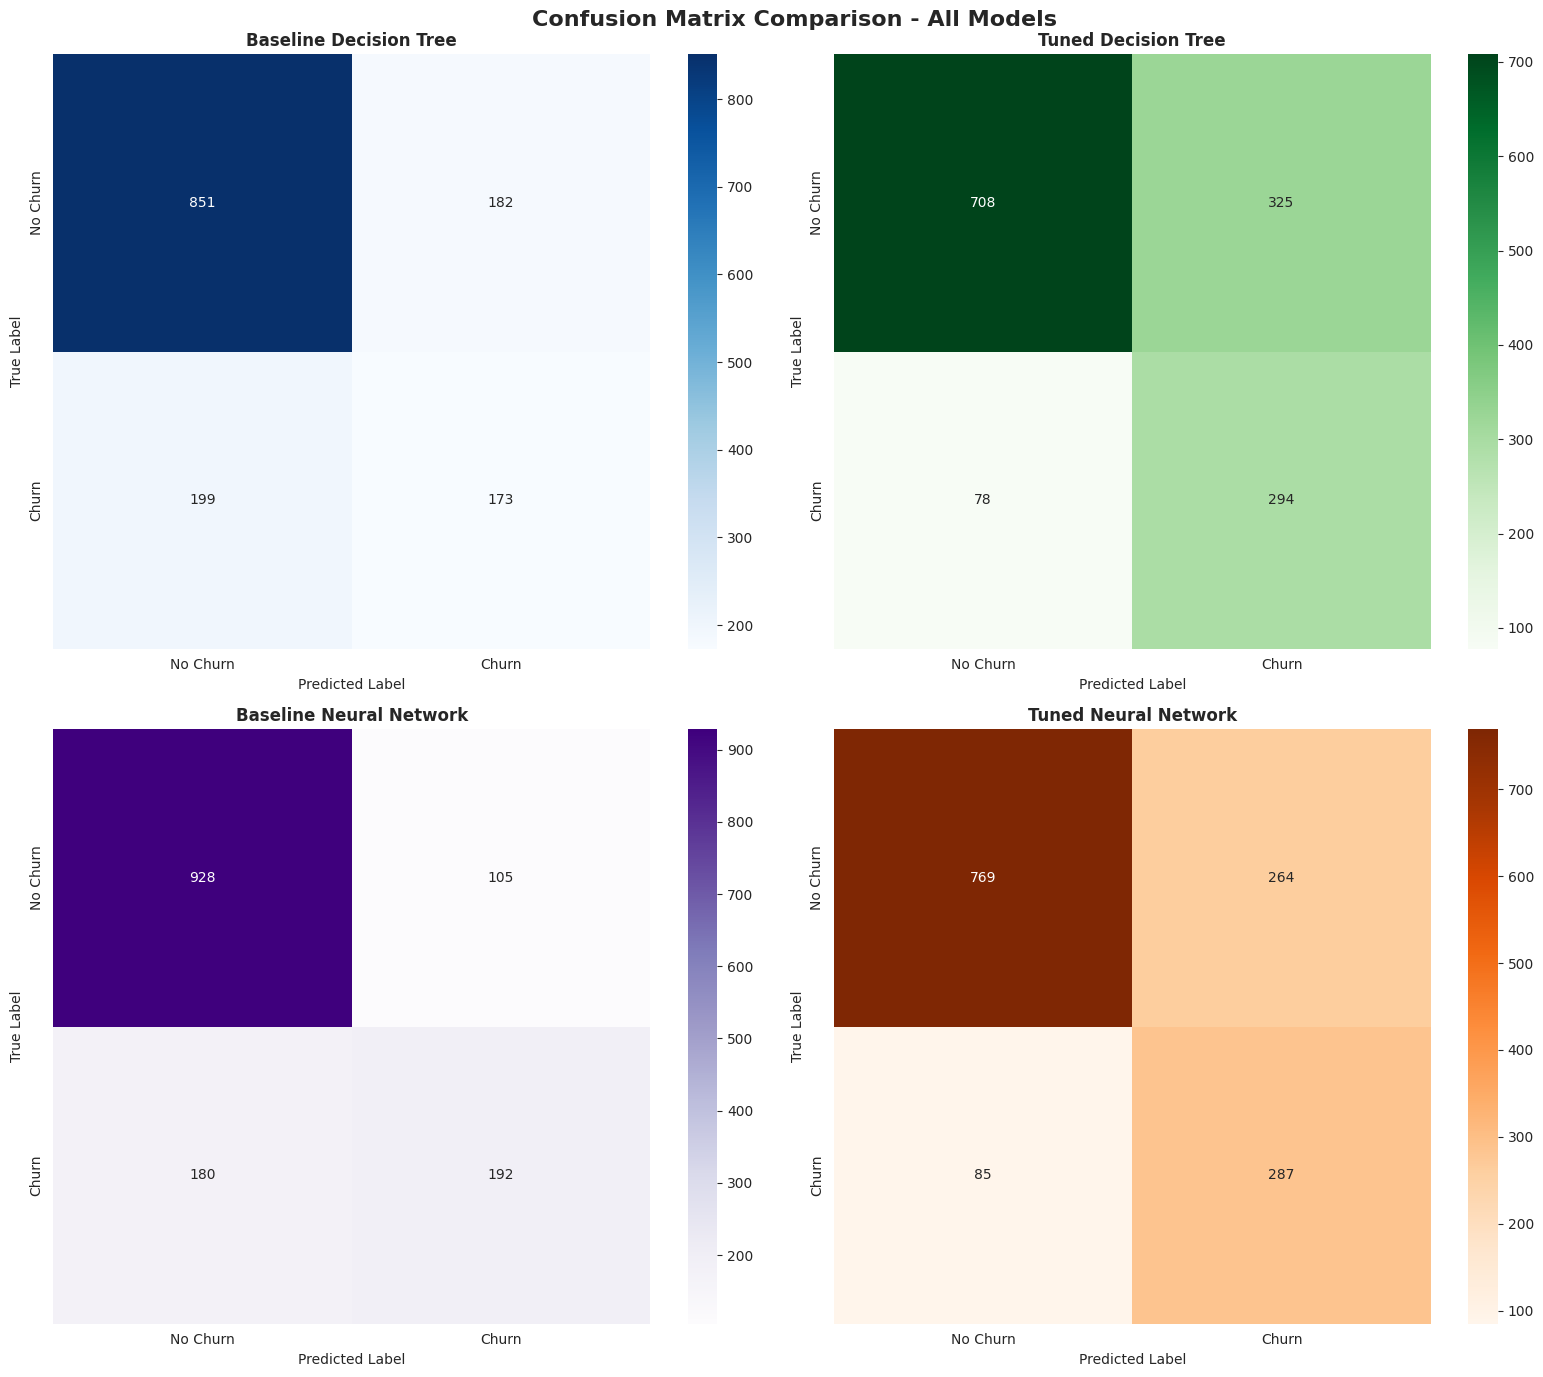


 All models perfomence visualization 



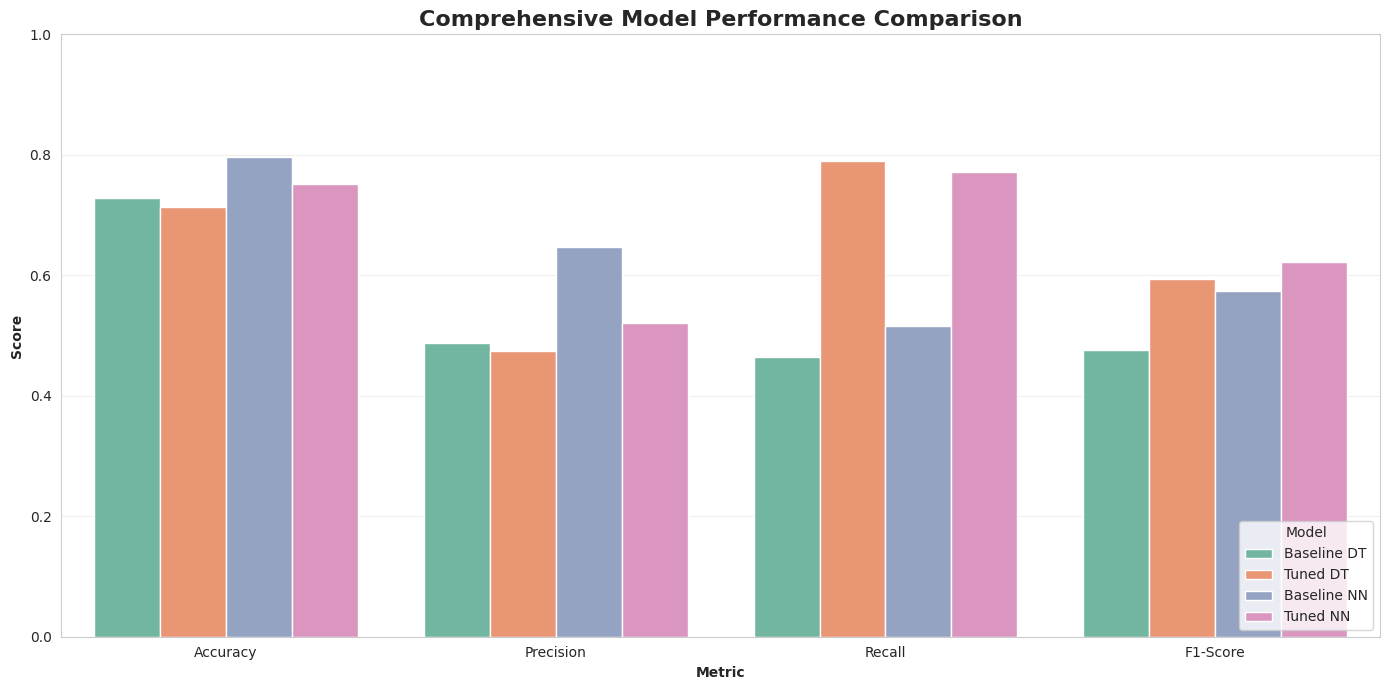


  ROC curve comparison 



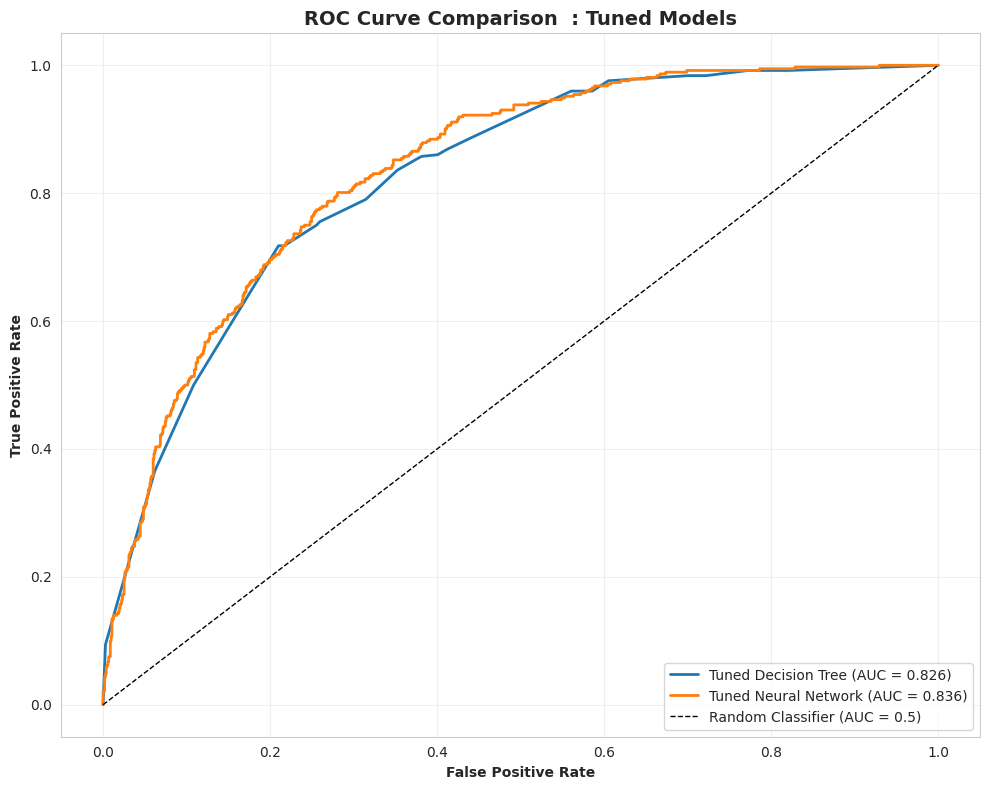


 ROC-AUC Scores:
   Tuned Decision Tree:   0.8258
   Tuned Neural Network:  0.8356

 Precision recall curve comparison 
 


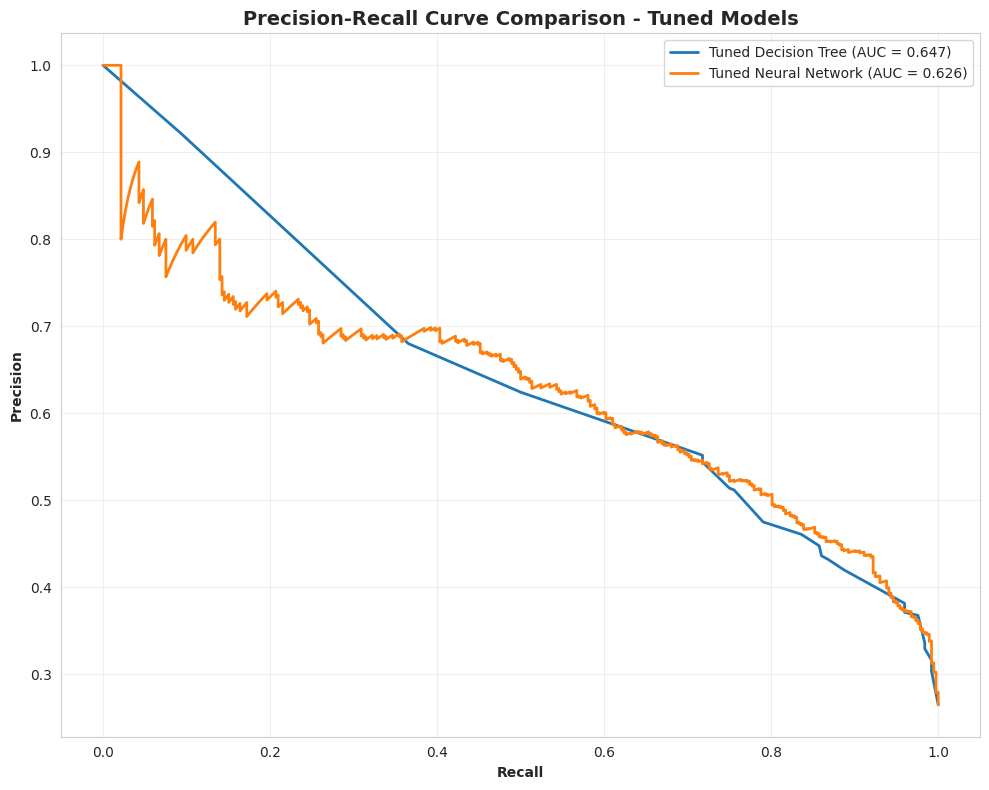


  Precision-Recall AUC Scores:
   Tuned Decision Tree:   0.6470
   Tuned Neural Network:  0.6261


In [ ]:
print("\n Base line NN model VS Tunned NN")

comparison_nn = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [
        nn_baseline_metrics['accuracy'],
        nn_baseline_metrics['precision'],
        nn_baseline_metrics['recall'],
        nn_baseline_metrics['f1']
    ],
    'Tuned': [
        nn_tuned_metrics['accuracy'],
        nn_tuned_metrics['precision'],
        nn_tuned_metrics['recall'],
        nn_tuned_metrics['f1']
    ]
})
comparison_nn['Improvement'] = comparison_nn['Tuned'] - comparison_nn['Baseline']

print(comparison_nn.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_nn['Metric']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_nn['Baseline'], width, label='Baseline', color='plum')
bars2 = ax.bar(x + width/2, comparison_nn['Tuned'], width, label='Tuned', color='coral')

ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Neural Network: Baseline vs Tuned Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_nn['Metric'])
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


# model comparison
print("\n model comparison \n")

# Create Comparison Table
print("\n Final model cmparison table \n")

final_comparison = pd.DataFrame({
    'Model': ['Baseline DT', 'Tuned DT', 'Baseline NN', 'Tuned NN'],
    'Accuracy': [
        dt_baseline_metrics['accuracy'],
        dt_tuned_metrics['accuracy'],
        nn_baseline_metrics['accuracy'],
        nn_tuned_metrics['accuracy']
    ],
    'Precision': [
        dt_baseline_metrics['precision'],
        dt_tuned_metrics['precision'],
        nn_baseline_metrics['precision'],
        nn_tuned_metrics['precision']
    ],
    'Recall': [
        dt_baseline_metrics['recall'],
        dt_tuned_metrics['recall'],
        nn_baseline_metrics['recall'],
        nn_tuned_metrics['recall']
    ],
    'F1-Score': [
        dt_baseline_metrics['f1'],
        dt_tuned_metrics['f1'],
        nn_baseline_metrics['f1'],
        nn_tuned_metrics['f1']
    ]
})

print("\n  final model comparison:")
print(final_comparison.to_string(index=False))

# Find best model
best_model_idx = final_comparison['F1-Score'].idxmax()
best_model_name = final_comparison.loc[best_model_idx, 'Model']
best_f1 = final_comparison.loc[best_model_idx, 'F1-Score']

print(f"\n  best model: {best_model_name} with F1-Score of {best_f1:.4f}")

#  Side by Side Confusion Matrix Comparison
print("\n Confusion Matrix Comparison for al model \n")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Confusion Matrix Comparison - All Models', fontsize=16, fontweight='bold')

# Define models and their confusion matrices
models_cm = [
    ('Baseline Decision Tree', cm_dt_baseline, 'Blues'),
    ('Tuned Decision Tree', cm_dt_tuned, 'Greens'),
    ('Baseline Neural Network', cm_nn_baseline, 'Purples'),
    ('Tuned Neural Network', cm_nn_tuned, 'Oranges')
]

for idx, (name, cm, cmap) in enumerate(models_cm):
    ax = axes[idx // 2, idx % 2]
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=True, ax=ax,
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    ax.set_title(name, fontweight='bold', fontsize=12)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Grouped Bar Chart for All Models
print("\n All models perfomence visualization \n")

# Melt dataframe for grouped bar chart
final_comparison_melted = final_comparison.melt(
    id_vars='Model',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(14, 7))
sns.barplot(data=final_comparison_melted, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xlabel('Metric', fontweight='bold')
plt.ylim(0, 1)
plt.legend(title='Model', loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ROC curve
print("\n  ROC curve comparison \n")

plt.figure(figsize=(10, 8))

# Decision Tree ROC
y_pred_dt_tuned_proba = best_dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_tuned_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Neural Network ROC
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_tuned_proba)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plot ROC curves
plt.plot(fpr_dt, tpr_dt, linewidth=2, label=f'Tuned Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot(fpr_nn, tpr_nn, linewidth=2, label=f'Tuned Neural Network (AUC = {roc_auc_nn:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5)')

plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curve Comparison  : Tuned Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n ROC-AUC Scores:")
print(f"   Tuned Decision Tree:   {roc_auc_dt:.4f}")
print(f"   Tuned Neural Network:  {roc_auc_nn:.4f}")

# 13.5: Precision-Recall Curves
print("\n Precision recall curve comparison \n ")

plt.figure(figsize=(10, 8))

# Decision Tree PR curve
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_dt_tuned_proba)
pr_auc_dt = auc(recall_dt, precision_dt)

# Neural Network PR curve
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_pred_nn_tuned_proba)
pr_auc_nn = auc(recall_nn, precision_nn)

# Plot PR curves
plt.plot(recall_dt, precision_dt, linewidth=2,
         label=f'Tuned Decision Tree (AUC = {pr_auc_dt:.3f})')
plt.plot(recall_nn, precision_nn, linewidth=2,
         label=f'Tuned Neural Network (AUC = {pr_auc_nn:.3f})')

plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.title('Precision-Recall Curve Comparison - Tuned Models', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n  Precision-Recall AUC Scores:")
print(f"   Tuned Decision Tree:   {pr_auc_dt:.4f}")
print(f"   Tuned Neural Network:  {pr_auc_nn:.4f}")

###Tuned Decision tree VS Tuned NN comparion

Tuned Models Comparison:
   Model  Accuracy  Precision   Recall  F1-Score
Tuned DT  0.713167   0.474960 0.790323  0.593340
Tuned NN  0.751601   0.520871 0.771505  0.621885



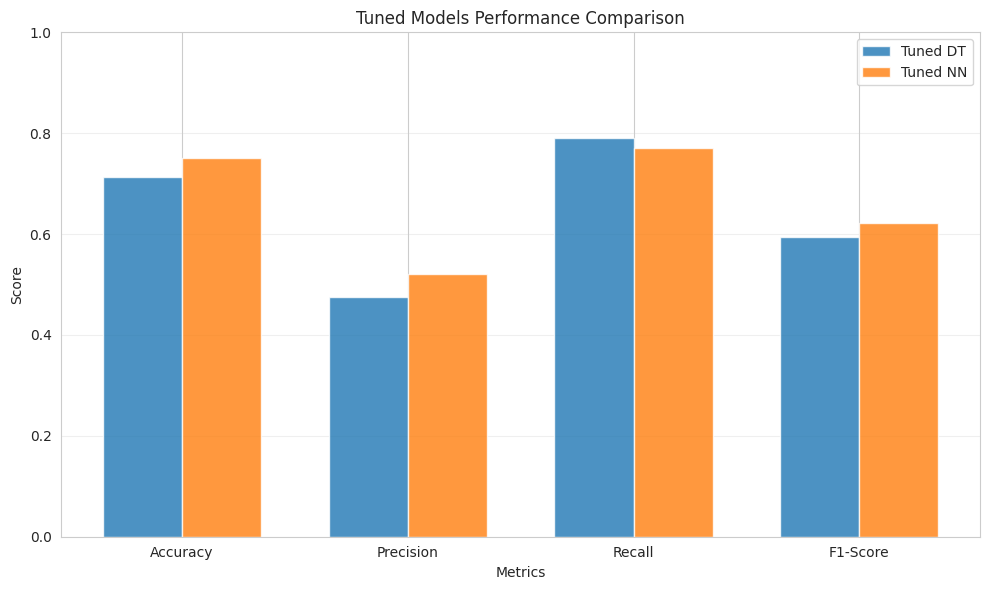

In [ ]:
# Compare Tuned DT and Tuned NN
tuned_comparison = pd.DataFrame({
    'Model': ['Tuned DT', 'Tuned NN'],
    'Accuracy': [
        dt_tuned_metrics['accuracy'],
        nn_tuned_metrics['accuracy']
    ],
    'Precision': [
        dt_tuned_metrics['precision'],
        nn_tuned_metrics['precision']
    ],
    'Recall': [
        dt_tuned_metrics['recall'],
        nn_tuned_metrics['recall']
    ],
    'F1-Score': [
        dt_tuned_metrics['f1'],
        nn_tuned_metrics['f1']
    ]
})

print("Tuned Models Comparison:")
print(tuned_comparison.to_string(index=False))
print()

# Visualization - Bar chart comparison
plt.figure(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, tuned_comparison.iloc[0, 1:], width, label='Tuned DT', alpha=0.8)
plt.bar(x + width/2, tuned_comparison.iloc[1, 1:], width, label='Tuned NN', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Tuned Models Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()